In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from matplotlib.gridspec import GridSpec

In [2]:
c = 1
mu0 = 1
epsilon0 = 1

class Slab_Waveguide:

    def __init__(self, **parameters):
        self.n1 = parameters.pop('n1', 1)
        self.n2 = parameters.pop('n2', 2)
        self.n3 = parameters.pop('n3', 1)
        self.d = parameters.pop('d', 1)
        self.a_TE = parameters.pop('a_TE', 0)
        self.a_TM = parameters.pop('a_TM', 0)
        self.P = parameters.pop('P',1)


    @property
    def asymmetry_TE(self):
        return (self.n1**2 - self.n3**2)/(self.n2**2 - self.n1**2)

    @property 
    def asymmetry_TM(self):
        return (self.n2**4/self.n3**4)*self.asymmetry_TE
    
    @property
    def h(self):
        return (1 - (self.n1/self.n2)**2)*(1 - (self.n3/self.n2)**2)
    
    def nu_cutoff_TE(self, m):
        if self.a_TE: 
            asymmetry_TE = self.a_TE
        else:
            asymmetry_TE = self.asymmetry_TE
        return m*np.pi + np.arctan(np.sqrt(asymmetry_TE))
    
    def nu_cutoff_TM(self, m):
        if self.a_TM: 
            asymmetry_TM = self.a_TM
        else:
            asymmetry_TM = self.asymmetry_TM
        return m*np.pi + np.arctan(np.sqrt(asymmetry_TM))

    def omega_cutoff_TE(self, m):
        return self.nu_cutoff_TE(m)*c/(self.d*np.sqrt(self.n2**2-self.n1**2))
    
    def omega_cutoff_TM(self, m):
        return self.nu_cutoff_TM(m)*c/(self.d*np.sqrt(self.n2**2-self.n1**2))

    def nu(self, omega):
        return omega*self.d*np.sqrt(self.n2**2-self.n1**2)/c

    def neff(self, omega, beta):
        return beta*c/omega

    def b_TE(self, neff):
        return (neff**2 - self.n1**2)/(self.n2**2 - self.n1**2)

    def q(self, neff):
        return (neff/self.n1)**2 + (neff/self.n2)**2 - 1

    def b_TM(self, neff):
        return self.n2**2/(self.q(neff)*self.n1**2)*self.b_TE(neff)

    def nu_vs_b_TE(self, b_TE, m):
        if self.a_TE: 
            asymmetry_TE = self.a_TE
        else:
            asymmetry_TE = self.asymmetry_TE
        return (m*np.pi + np.arctan(np.sqrt(b_TE/(1-b_TE))) + np.arctan(np.sqrt((b_TE+asymmetry_TE)/(1-b_TE))))/np.sqrt(1-b_TE)

    def b_TM_to_neff(self, b_TM):
        num = b_TM*self.n1**2*self.n2**2*(self.n2**2-self.n1**2) - self.n2**4*self.n1**2
        den = b_TM*(self.n2**4 - self.n1**4) - self.n2**4
        return np.sqrt(num/den)

    def nu_vs_b_TM(self, b_TM, m):
        if self.a_TM: 
            asymmetry_TM = self.a_TM
        else:
            asymmetry_TM = self.asymmetry_TM
        neff = self.b_TM_to_neff(b_TM)
        return self.n1/(self.n2*np.sqrt(self.q(neff)*(1-b_TM)))*(m*np.pi + np.arctan(np.sqrt(b_TM/(1-b_TM))) + np.arctan(np.sqrt((b_TM+asymmetry_TM*(1 - b_TM*self.h))/(1-b_TM))))

    def implicit_dispersion_relation_TE(self, b_TE, nu, m):
        return self.nu_vs_b_TE(b_TE,m) - nu
    
    def implicit_dispersion_relation_TM(self, b_TM, nu, m):
        return self.nu_vs_b_TM(b_TM,m) - nu

    def find_allowed_beta_TE(self, omega, m):
        beta_min = self.n1*omega*1.01
        beta_max = self.n2*omega*0.99
        betas = np.linspace(beta_min,beta_max, 1000)
        if self.nu(omega) >= self.nu_cutoff_TE(m):
            f = self.implicit_dispersion_relation_TE(self.b_TE(self.neff(omega,betas)),self.nu(omega),m)
            #initial_guess = betas[np.nanargmin(np.abs(f))]
            #root = optimize.root(self.implicit_dispersion_relation_TE,initial_guess,args = (self.nu(omega),m))
            #allowed_beta = root.x
            allowed_beta = betas[np.nanargmin(np.abs(f))]
        else:
            allowed_beta = None
        return allowed_beta
    
    def find_allowed_beta_TM(self, omega, m):
        beta_min = self.n1*omega*1.01
        beta_max = self.n2*omega*0.99
        betas = np.linspace(beta_min,beta_max, 1000)
        if self.nu(omega) >= self.nu_cutoff_TM(m):
            f = self.implicit_dispersion_relation_TM(self.b_TM(self.neff(omega,betas)),self.nu(omega),m)
            #initial_guess = betas[np.nanargmin(np.abs(f))]
            #root = optimize.root(self.implicit_dispersion_relation_TE,initial_guess,args = (self.nu(omega),m))
            #allowed_beta = root.x
            allowed_beta = betas[np.nanargmin(np.abs(f))]
        else:
            allowed_beta = None
        return allowed_beta

    def TE(self, x, beta, omega):   
        if beta:
            k0 = omega/c
            kappa1 = np.sqrt(beta**2 - self.n1**2*k0**2) 
            k2 = np.sqrt(self.n2**2*k0**2 - beta**2) 
            kappa3 = np.sqrt(beta**2 - self.n3**2*k0**2) 

            A = 2*k2*np.sqrt(omega*mu0*self.P/(beta*(k2**2 + kappa3**2)*(self.d + 1/kappa1 + 1/kappa3)))

            x1 = x[np.where(x<-self.d/2)[0]]
            x2 = x[np.where((x>=-self.d/2) & (x<self.d/2))[0]]
            x3 = x[np.where(x>=self.d/2)[0]]

            ey1 = A*np.exp(kappa1*(x1+self.d/2))
            ey2 = A*(np.cos(k2*(x2+self.d/2)) + kappa1/k2*np.sin(k2*(x2+self.d/2)))
            ey3 = A*(np.cos(k2*self.d) + kappa1/k2*np.sin(k2*self.d))*np.exp(-kappa3*(x3-self.d/2))
            ey = np.concatenate((ey1,ey2,ey3))

            hx = -beta/(omega*mu0)*ey 

            hz1 = A*1j/(omega*mu0)*kappa1*np.exp(kappa1*(x1+self.d/2))
            hz2 = A*1j/(omega*mu0)*(-k2*np.sin(k2*(x2+self.d/2)) + kappa1*np.cos(k2*(x2+self.d/2)))
            hz3 = -A*1j/(omega*mu0)*(np.cos(k2*self.d) + kappa1/k2*np.sin(k2*self.d))*kappa3*np.exp(-kappa3*(x3-self.d/2))
            hz = np.imag(np.concatenate((hz1,hz2,hz3)))

        else:
            ey = np.full(x.size, np.nan)
            hx = np.full(x.size, np.nan)
            hz = np.full(x.size, np.nan)
            print("No betas allowed for this set of parameters")
        return ey, hx, hz
    
    def TM(self, x, beta, omega):   
        if beta:     
            k0 = omega/c
            kappa1 = np.sqrt(beta**2 - self.n1**2*k0**2) 
            k2 = np.sqrt(self.n2**2*k0**2 - beta**2) 
            kappa3 = np.sqrt(beta**2 - self.n3**2*k0**2) 

            Cnum = omega*epsilon0*self.P
            Cden = beta*(self.n3**4*k2**2 + self.n2**4*kappa3**2)*(self.d + self.n1**2*self.n2**2*(k2**2 + kappa1**2)/(kappa1*(self.n1**4*k2**2 + self.n2**4*kappa1**2)) + self.n2**2*self.n3**2*(k2**2 + kappa3**2)/(self.n3**4*k2**2 + self.n2**4*kappa3**2))
            C = 2*self.n2*self.n3**2*k2*np.sqrt(Cnum/Cden)

            x1 = x[np.where(x<-self.d/2)[0]]
            x2 = x[np.where((x>=-self.d/2) & (x<self.d/2))[0]]
            x3 = x[np.where(x>=self.d/2)[0]]

            hy1 = C*np.exp(kappa1*(x1+self.d/2))
            hy2 = C*(np.cos(k2*(x2+self.d/2)) + self.n2**2/self.n1**2*kappa1/k2*np.sin(k2*(x2+self.d/2)))
            hy3 = C*(np.cos(k2*self.d) + self.n2**2/self.n1**2*kappa1/k2*np.sin(k2*self.d))*np.exp(-kappa3*(x3-self.d/2))
            hy = np.concatenate((hy1,hy2,hy3))

            ex1 = beta/(omega*epsilon0*self.n1**2)*hy1 
            ex2 = beta/(omega*epsilon0*self.n2**2)*hy2 
            ex3 = beta/(omega*epsilon0*self.n3**2)*hy3 
            ex = np.concatenate((ex1,ex2,ex3))

            ez1 = -C*1j/(omega*epsilon0*self.n1**2)*kappa1*np.exp(kappa1*(x1+self.d/2))
            ez2 = -C*1j/(omega*epsilon0*self.n2**2)*(-k2*np.sin(k2*(x2+self.d/2)) + self.n2**2/self.n1**2*kappa1*np.cos(k2*(x2+self.d/2)))
            ez3 = C*1j/(omega*epsilon0*self.n3**2)*(np.cos(k2*self.d) + self.n2**2/self.n1**2*kappa1/k2*np.sin(k2*self.d))*kappa3*np.exp(-kappa3*(x3-self.d/2))
            ez = np.imag(np.concatenate((ez1,ez2,ez3)))
        
        else:
            hy = np.full(x.size, np.nan)
            ex = np.full(x.size, np.nan)
            ez = np.full(x.size, np.nan)
            print("No betas allowed for this set of parameters")
        return hy, ex, ez

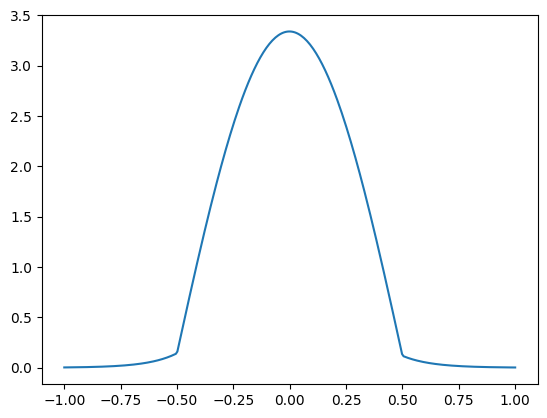

In [3]:
d = 1
n1 = 1
n2 = 3
n3 = 1

slab_waveguide = Slab_Waveguide(n1 = n1, n2 = n2, n3 = n3, d = d)
xmin = -1
xmax = 1
x = np.linspace(xmin,xmax,300)

omega = 3
beta = slab_waveguide.find_allowed_beta_TM(omega,0)
plt.plot(x,slab_waveguide.TM(x,beta,omega)[0])
plt.show()


## All properties of a single set of parameters

In [4]:
### define properties of the slab waveguide
d = 2
n1 = 1
n2 = 5
n3 = 1

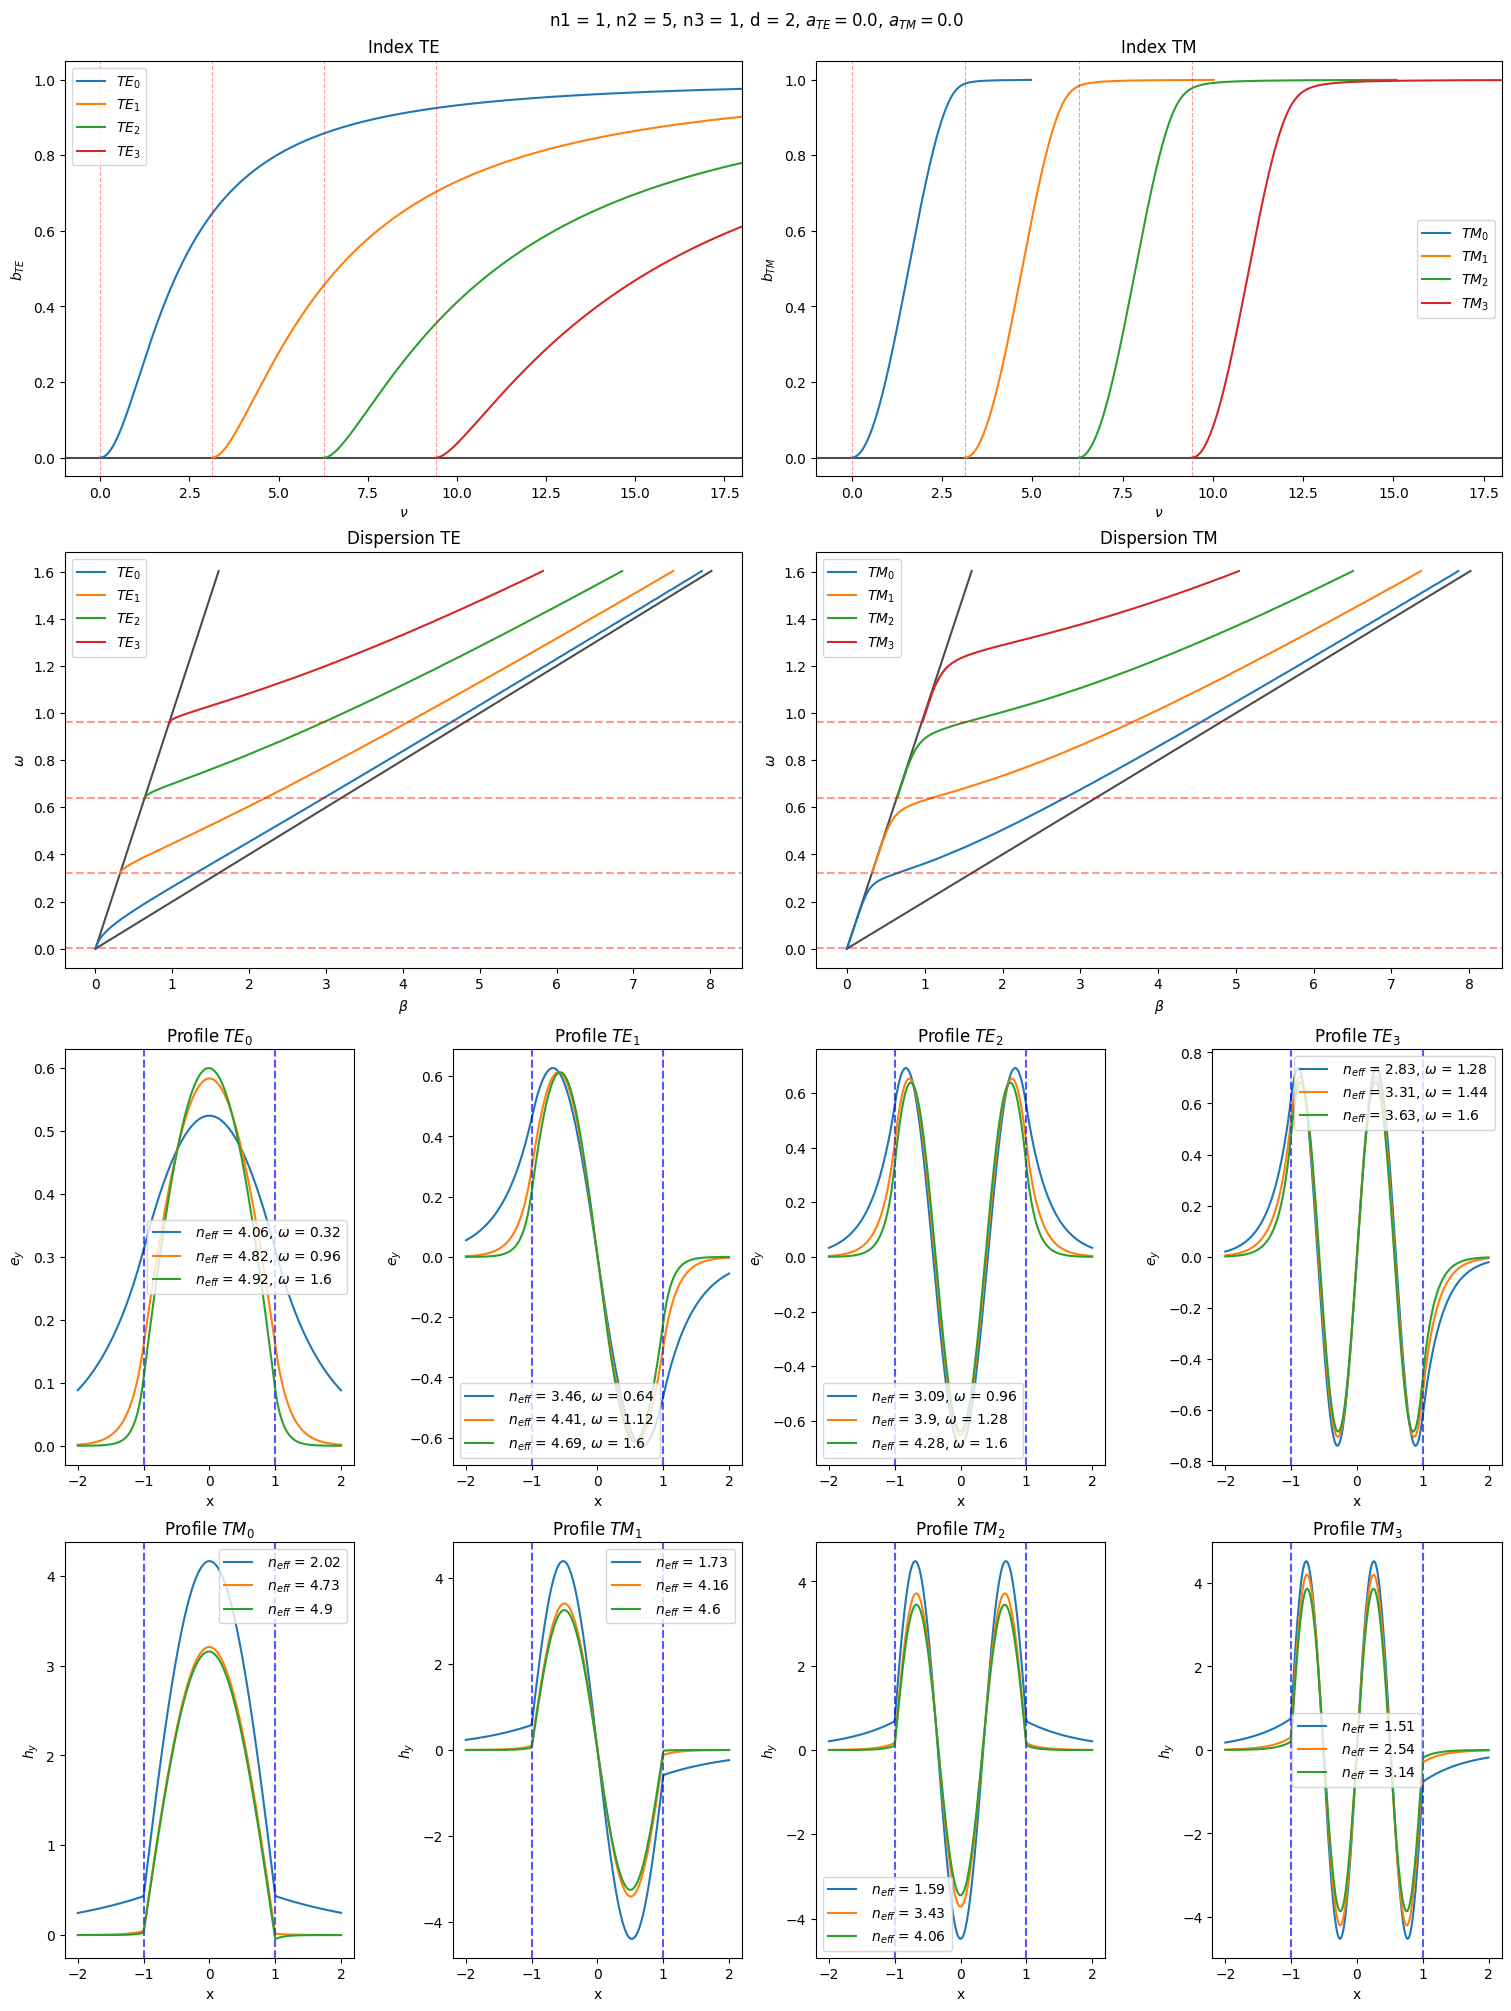

In [5]:
### compute the properties

slab_waveguide = Slab_Waveguide(n1 = n1, n2 = n2, n3 = n3, d = d)
n_modes = 4
max_omega = slab_waveguide.omega_cutoff_TE(n_modes + 1)
n_omega = 500
omegas = np.linspace(0,max_omega,n_omega)

b = np.linspace(0,0.999,1000)
x = np.linspace(-2,2,300)

fig = plt.figure(layout = "constrained", figsize = (15,20))

fig.suptitle(f'n1 = {n1}, n2 = {n2}, n3 = {n3}, d = {d}, $a_{{TE}} = {round(slab_waveguide.asymmetry_TE,2)}$, $a_{{TM}} = {round(slab_waveguide.asymmetry_TM,2)}$')
gs = GridSpec(4, 4, figure=fig)

index_TE = fig.add_subplot(gs[0, :2])
index_TE.set_title('Index TE')
index_TE.axhline(0, color = 'black', alpha = 0.7)
index_TE.set_xlabel(r"$\nu$")
index_TE.set_ylabel("$b_{TE}$")
index_TE.set_xlim(-1,18)

index_TM = fig.add_subplot(gs[0, 2:])
index_TM.set_title('Index TM')
index_TM.axhline(0, color = 'black', alpha = 0.7)
index_TM.set_xlabel(r"$\nu$")
index_TM.set_ylabel("$b_{TM}$")
index_TM.set_xlim(-1,18)

dispersion_TE = fig.add_subplot(gs[1, :2])
dispersion_TE.set_title('Dispersion TE')
dispersion_TE.plot(omegas*n2,omegas,color = 'black', alpha = 0.7)
dispersion_TE.plot(omegas*n1,omegas, color = 'black', alpha = 0.7)

dispersion_TM = fig.add_subplot(gs[1, 2:])
dispersion_TM.set_title('Dispersion TM')
dispersion_TM.plot(omegas*n2,omegas,color = 'black', alpha = 0.7)
dispersion_TM.plot(omegas*n1,omegas, color = 'black', alpha = 0.7)

for m in range(0,n_modes):     
    index_TE.axvline(slab_waveguide.nu_cutoff_TE(m), linestyle = '--', linewidth = 0.8, alpha = 0.4, color = 'red')
    index_TE.plot(slab_waveguide.nu_vs_b_TE(b,m),b, label = f'$TE_{m}$')
    index_TM.axvline(slab_waveguide.nu_cutoff_TM(m), linestyle = '--', linewidth = 0.8, alpha = 0.4, color = 'red')
    index_TM.plot(slab_waveguide.nu_vs_b_TM(b,m),b, label = f'$TM_{m}$')

    new_omega_cutoff = slab_waveguide.omega_cutoff_TE(m)
    if new_omega_cutoff == 0:
        new_omega_cutoff = 0.001
    omegas = np.linspace(new_omega_cutoff,max_omega,n_omega)    
    allowed_betas = []
    for omega in omegas:
        allowed_beta = slab_waveguide.find_allowed_beta_TE(omega,m)
        allowed_betas = np.append(allowed_betas, allowed_beta) 
    dispersion_TE.plot(allowed_betas, omegas, label = f'$TE_{m}$')
    dispersion_TE.set_ylabel("$\omega$")
    dispersion_TE.set_xlabel(r"$\beta$")
    dispersion_TE.axhline(new_omega_cutoff, linestyle = '--', alpha = 0.4, color = 'red')

    new_omega_cutoff = slab_waveguide.omega_cutoff_TM(m)
    if new_omega_cutoff == 0:
        new_omega_cutoff = 0.001
    omegas = np.linspace(new_omega_cutoff,max_omega,n_omega)    
    allowed_betas = []
    for omega in omegas:
        allowed_beta = slab_waveguide.find_allowed_beta_TM(omega,m)
        allowed_betas = np.append(allowed_betas, allowed_beta) 
    dispersion_TM.plot(allowed_betas, omegas, label = f'$TM_{m}$')
    dispersion_TM.set_ylabel("$\omega$")
    dispersion_TM.set_xlabel(r"$\beta$")
    dispersion_TM.axhline(new_omega_cutoff, linestyle = '--', alpha = 0.4, color = 'red')

    profile_TE = fig.add_subplot(gs[2, m])
    profile_TM = fig.add_subplot(gs[3, m])
    omegas = np.linspace(slab_waveguide.omega_cutoff_TE(m+1),max_omega,3)
    for omega in omegas:
        beta = slab_waveguide.find_allowed_beta_TE(omega,m) 
        profile_TE.set_title(f'Profile $TE_{m}$')
        if beta:
            profile_TE.plot(x, slab_waveguide.TE(x,beta,omega)[0], label = f' $n_{{eff}}$ = {round(slab_waveguide.neff(omega,beta),2)}, $\omega$ = {round(omega,2)}')
            profile_TE.legend()
        profile_TE.axvline(-d/2, linestyle = '--', alpha = 0.3, color = 'blue')
        profile_TE.axvline(d/2, linestyle = '--', alpha = 0.3, color = 'blue')
        profile_TE.set_xlabel('x')
        profile_TE.set_ylabel(f'$e_y$')
        
        beta = slab_waveguide.find_allowed_beta_TM(omega,m)    
        profile_TM.set_title(f'Profile $TM_{m}$')
        if beta:
            profile_TM.plot(x, slab_waveguide.TM(x,beta,omega)[0], label = f' $n_{{eff}}$ = {round(slab_waveguide.neff(omega,beta),2)}')
            profile_TM.legend()
        profile_TM.axvline(-d/2, linestyle = '--', alpha = 0.3, color = 'blue')
        profile_TM.axvline(d/2, linestyle = '--', alpha = 0.3, color = 'blue')
        profile_TM.set_xlabel('x')
        profile_TM.set_ylabel(f'$h_y$')
        
index_TE.legend()
index_TM.legend() 
dispersion_TE.legend()  
dispersion_TM.legend()
plt.show()

## TE Compare normalized index for different asymmetries and different modes 

In [ ]:
d = 1
b = np.linspace(0,0.99,100)
plt.axhline(0, color = 'black', alpha = 0.7)
for m in range(0,3):  
    for a_TE in np.linspace(0,4,3): 
        slab_waveguide = Slab_Waveguide(a_TE = a_TE, d = d)     
        plt.axvline(slab_waveguide.nu_cutoff_TE(m), linestyle = '--', linewidth = 0.8, alpha = 0.4, color = 'red')
        plt.plot(slab_waveguide.nu_vs_b_TE(b,m),b, label = f'$TE_{m}, a_{{TE}} = {a_TE}$')

plt.xlabel(r"$\nu$")
plt.ylabel("$b_{TE}$")
plt.xlim(-1,20)
plt.legend()
plt.show()

## TE Compare dispersion relation for different modes

In [ ]:
d = 1
n1 = 1
n2 = 3
n3 = 1

fig, ax = plt.subplots(ncols = 3, figsize = (15,5))

col = 0
for d in np.linspace(1,3,3):
    max_omega = 5
    n_omega = 500
    omegas = np.linspace(0,max_omega,n_omega)
    ax[col].set_title(f'd = {d}')
    ax[col].plot(omegas*n2,omegas,color = 'black', alpha = 0.7)
    ax[col].plot(omegas*n1,omegas, color = 'black', alpha = 0.7)

    slab_waveguide = Slab_Waveguide(n1 = n1, n2 = n2, n3 = n3, d = d)
    for m in range(0,4):
        new_omega_cutoff = slab_waveguide.omega_cutoff_TE(m)
        if new_omega_cutoff == 0:
            new_omega_cutoff = 0.001
        omegas = np.linspace(new_omega_cutoff,max_omega,n_omega)    
        allowed_betas = []
        for omega in omegas:
            allowed_beta = slab_waveguide.find_allowed_beta_TE(omega,m)
            allowed_betas = np.append(allowed_betas, allowed_beta) 
        ax[col].plot(allowed_betas, omegas, label = f'$TE_{m}$')
        ax[col].set_ylabel("$\omega$")
        ax[col].set_xlabel(r"$\beta$")
        ax[col].axhline(new_omega_cutoff, linestyle = '--', alpha = 0.4, color = 'red')

    ax[col].legend()
    col = col + 1

plt.show()

## TE Mode Profile as Function of Effective Index 

In [ ]:
d = 1
n1 = 1
n2 = 3
n3 = 1

ncols = 3
component_labels = ['$e_y$', '$h_x$', '$h_z$']
fig, ax = plt.subplots(ncols=3, nrows=3, figsize = (18,20))

slab_waveguide = Slab_Waveguide(n1 = n1, n2 = n2, n3 = n3, d = d)
x = np.linspace(-2,2,300)
omegas = np.linspace(0.4,4,3)
for m in range(0,ncols):
    for omega in omegas:
        for component in range(0,3):
            beta = slab_waveguide.find_allowed_beta_TE(omega,m)
            ax[component][m].set_title(f'$TE_{m}$')
            ax[component][m].plot(x, slab_waveguide.TE(x,beta,omega)[component], label = f' $\omega$ = {omega}')
            ax[component][m].axvline(-d/2, linestyle = '--', alpha = 0.3, color = 'blue')
            ax[component][m].axvline(d/2, linestyle = '--', alpha = 0.3, color = 'blue')
            ax[component][m].set_xlabel('x')
            ax[component][m].set_ylabel(f'{component_labels[component]}')
            ax[component][m].legend()

## TE Mode Profile as Function of Asymmetry

In [ ]:
d = 1
n1 = 1
n2 = 3
n3 = 1

ncols = 3
component_labels = ['$e_y$', '$h_x$', '$h_z$']
fig, ax = plt.subplots(ncols=3, nrows=3, figsize = (18,20))

omega = 4
col = 0
for m in range(0,ncols):
    for n1 in np.linspace(1,0.9*n2,3):   
        for component in range(0,3):
            slab_waveguide = Slab_Waveguide(n1 = n1, n2 = n2, n3 = n3, d = d)
            beta = slab_waveguide.find_allowed_beta_TE(omega,m)
            ax[component][col].set_title(f'$TE_{m}$')
            ax[component][col].plot(x, slab_waveguide.TE(x,beta,omega)[component], label = f' $a_{{TE}}$ = {round(slab_waveguide.asymmetry_TE,2)}')
            ax[component][col].axvline(-d/2, linestyle = '--', alpha = 0.3, color = 'blue')
            ax[component][col].axvline(d/2, linestyle = '--', alpha = 0.3, color = 'blue')
            ax[component][col].set_xlabel('x')
            ax[component][col].set_ylabel(f'{component_labels[component]}')
            ax[component][col].legend()
    col = col + 1

## TM Compare normalized index for different asymmetries and different modes 

In [ ]:
d = 1
b = np.linspace(0,0.999,1000)
plt.axhline(0, color = 'black', alpha = 0.7)
for m in range(0,3):  
    for a_TM in np.linspace(0,4,3): 
        slab_waveguide = Slab_Waveguide(a_TM = a_TM, d = d)     
        plt.axvline(slab_waveguide.nu_cutoff_TM(m), linestyle = '--', linewidth = 0.8, alpha = 0.4, color = 'red')
        plt.plot(slab_waveguide.nu_vs_b_TM(b,m),b, label = f'$TM_{m}, a_{{TM}} = {a_TM}$')

plt.xlabel(r"$\nu$")
plt.ylabel("$b_{TM}$")
plt.xlim(-1,18)
plt.legend()
plt.show()

## TM Compare dispersion relation for different modes

In [ ]:
d = 1
n1 = 1
n2 = 3
n3 = 1

fig, ax = plt.subplots(ncols = 3, figsize = (15,5))

col = 0
for d in np.linspace(1,3,3):
    max_omega = 5
    n_omega = 500
    omegas = np.linspace(0,max_omega,n_omega)
    ax[col].set_title(f'd = {d}')
    ax[col].plot(omegas*n2,omegas,color = 'black', alpha = 0.7)
    ax[col].plot(omegas*n1,omegas, color = 'black', alpha = 0.7)

    slab_waveguide = Slab_Waveguide(n1 = n1, n2 = n2, n3 = n3, d = d)
    for m in range(0,4):
        new_omega_cutoff = slab_waveguide.omega_cutoff_TM(m)
        if new_omega_cutoff == 0:
            new_omega_cutoff = 0.001
        omegas = np.linspace(new_omega_cutoff,max_omega,n_omega)    
        allowed_betas = []
        for omega in omegas:
            allowed_beta = slab_waveguide.find_allowed_beta_TM(omega,m)
            allowed_betas = np.append(allowed_betas, allowed_beta) 
        ax[col].plot(allowed_betas, omegas, label = f'$TM_{m}$')
        ax[col].set_ylabel("$\omega$")
        ax[col].set_xlabel(r"$\beta$")
        ax[col].axhline(new_omega_cutoff, linestyle = '--', alpha = 0.4, color = 'red')

    ax[col].legend()
    col = col + 1

plt.show()

## TM Mode profile

In [ ]:
d = 1
n1 = 1
n2 = 3
n3 = 1

ncols = 3
fig, ax = plt.subplots(ncols=ncols, nrows=2, figsize = (18,10))

slab_waveguide = Slab_Waveguide(n1 = n1, n2 = n2, n3 = n3, d = d)
x = np.linspace(-2,2,300)
omegas = np.linspace(0.4,4,3)
for m in range(0,ncols):
    for omega in omegas:
        beta = slab_waveguide.find_allowed_beta_TM(omega,m)
        ax[0][m].set_title(f'$TM_{m}$')
        ax[0][m].plot(x, slab_waveguide.TM(x,beta,omega)[0], label = f' $\omega$ = {omega}')
        ax[0][m].axvline(-d/2, linestyle = '--', alpha = 0.3, color = 'blue')
        ax[0][m].axvline(d/2, linestyle = '--', alpha = 0.3, color = 'blue')
        ax[0][m].set_xlabel('x')
        ax[0][m].set_ylabel('$h_y$')
    ax[0][m].legend()

omega = 3
col = 0
for m in range(0,ncols):
    for n1 in np.linspace(1,0.5*n2,3):   
        slab_waveguide = Slab_Waveguide(n1 = n1, n2 = n2, n3 = n3, d = d)
        beta = slab_waveguide.find_allowed_beta_TM(omega,m)
        ax[1][col].set_title(f'$TM_{m}$')
        ax[1][col].plot(x, slab_waveguide.TM(x,beta,omega)[0], label = f' $a_{{TM}}$ = {round(slab_waveguide.asymmetry_TM,2)}')
        ax[1][col].axvline(-d/2, linestyle = '--', alpha = 0.3, color = 'blue')
        ax[1][col].axvline(d/2, linestyle = '--', alpha = 0.3, color = 'blue')
        ax[1][col].set_xlabel('x')
        ax[1][col].set_ylabel(r'$h_y$')
    ax[1][col].legend()
    col = col + 1


In [ ]:
N = 500
a = np.vstack([slab_waveguide.TM(x,beta,omega)[0]]*N)
plt.imshow(a.T, extent = [xmin,xmax,xmin,xmax], cmap = 'hot')
plt.colorbar()
plt.show()